## OpenAI Assistant API Multi-Agent Example

### About this example
The example provided in this notebook helps demonstrate how to build a multi-agent framework with Assistant API and serves as a comprehensive guide for developers looking to harness the capabilities of multiple AI agents working in concert. The crux of the article is to showcase how agents can communicate and collaborate to process complex tasks, such as generating and enhancing images through multiple iterations based on user input. This is particularly relevant for developers and tech enthusiasts who are interested in exploring the frontiers of generative AI and multi-agent systems.

Before getting started, one should have a basic understanding of AI and an interest in how agents can work together to enhance AI functionalities. The article does not delve into in-depth programming; however, a general knowledge of how APIs operate and the role of AI in automated systems would be beneficial in grasping the concepts presented. This example is an invitation to innovators and developers who wish to experiment with advanced AI systems and potentially integrate them into various industry solutions.

In [53]:
import os
import sys
import time
import json
from matplotlib import pyplot as plt
import cv2
import requests
from PIL import Image
from pathlib import Path

import wikipedia
from typing import Dict, Optional
from openai import OpenAI

from openai.types.beta import Thread
from openai.types.beta import Assistant

from loguru import logger

from dotenv import load_dotenv

In [13]:
load_dotenv()

True

In [56]:
assistant_client = OpenAI()

## Create the holiday agent

In [57]:
name = "holiday_assistant"
model = "gpt-4o-mini"
instructions = """You are a helpful assistant that create a personalized holiday itinerary for the user based on their preferences.

Steps:
1.  Use Web Browser to research destination: Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects.
2.  If place or location is not present Ask user for: destination 
3.  Use Weather Retrieval for current/forecasted weather for the destination.
4.  Create detailed daily itinerary: activities, transport, food, times, costs.
5.  Personalize: tailor to interests, provide recommendations.
6.  Present itinerary, get feedback, revise.
7.  Include safety/cultural info.
8.  Format clearly."""

weather_tool ={
      "type": "function",
      "function": {
        "name": "get_current_temperature",
        "description": "Get the current temperature for a specific location",
        "parameters": {
          "type": "object",
          "properties": {
            "city_name": {
              "type": "string",
              "description": "The city and state, e.g., San Francisco, CA"
            }
          },
          "required": ["location"]
        }
      }
    }

def get_current_temperature(city_name):
    base_url = "http://api.openweathermap.org/data/2.5/weather?"

    WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")

    complete_url = base_url + "appid=" + WEATHER_API_KEY + "&q=" + city_name

    response = requests.get(complete_url)

    x = response.json()

    if x["cod"] != "404":
 
        # store the value of "main"
        # key in variable y
        y = x["main"]
    
        # store the value corresponding
        # to the "temp" key of y
        current_temperature = y["temp"] - 273.15      
    
        # store the value of "weather"
        # key in variable z
        z = x["weather"]
    
        # store the value corresponding 
        # to the "description" key at 
        # the 0th index of z
        weather_description = str(z[0]["description"])

        output = f"Current temperature in {city_name}: {current_temperature}°C and it is {weather_description}"
    else:
        output = f"Error: City {city_name} is not found"

    return output

wiki_tool = {
  "type": "function",
  "function": {
    "name": "wiki_api_caller",
    "description": "Searches Wikipedia for information.",
    "parameters": {
      "type": "object",
      "properties": {
        "query": {
          "type": "string",
          "description": "The search query."
        }
      },
      "required": ["query"]
    }
  }
}


def wiki_api_caller(query):
    try:
        results = wikipedia.search(query)
        if results:
            summary = wikipedia.summary(results[0], sentences=5)  # Get summary of the top result
            return {"result": summary}
        else:
            return {"error": "No results found on Wikipedia."}
    except wikipedia.exceptions.DisambiguationError as e:
        return {"error": f"Multiple results found. Please be more specific. Options: {e.options}"}
    except wikipedia.exceptions.PageError:
        return {"error": "Page not found on Wikipedia."}
    except Exception as e:
        return {"error": f"An error occurred: {str(e)}"}

In [58]:
holiday_assistant = assistant_client.beta.assistants.create(
    name=name, instructions=instructions, model=model, tools=[wiki_tool, weather_tool]
)

## Create the Image Generator agent

In [59]:
name_dl = "image_generator_assistant"
model = "gpt-4o-mini"
instructions_dl = """As a premier AI specializing in image generation, you possess the expertise to craft precise visuals based on given prompts. It is essential that you diligently generate the requested image, ensuring its accuracy and alignment with the user's specifications, prior to delivering a response."""
tools = [
    {
        "type": "function",
        "function": {
            "name": "generate_image",
            "description": "Creates and displays an image",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {
                        "type": "string",
                        "description": "The prompt to be used to create the image",
                    }
                },
                "required": ["prompt"],
            },
        },
    }
]

verbose_output = True


def generate_image(prompt: str) -> str:
    
    print("Dalle Assistant Message: Creating the image ...")

    response = assistant_client.images.generate(
        model="dall-e-3", prompt=prompt, size="1024x1024", quality="standard", n=1
    )

    # Retrieve the image URL from the response (assuming response structure)
    image_url = response.data[0].url

    # Open the image from the URL and save it to a temporary file.
    im = Image.open(requests.get(image_url, stream=True).raw)

    # Define the filename and path where the image should be saved.
    filename = "temp.jpg"
    local_path = Path(filename)

    # Save the image.
    im.save(local_path)

    # Get the absolute path of the saved image.
    full_path = str(local_path.absolute())

    img = cv2.imread("temp.jpg", cv2.IMREAD_UNCHANGED)

    # Convert the image from BGR to RGB for displaying with matplotlib,
    # because OpenCV uses BGR by default and matplotlib expects RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib.
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels.
    plt.show()

    # Return the full path of the saved image.
    print("Dalle Assistant Message: " + full_path)
    return "Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant"


In [60]:
#Image generator assistant initialization

dalle_assistant = assistant_client.beta.assistants.create(
    name=name_dl, instructions=instructions_dl, model=model, tools=tools
)

## Create the User Proxy Agent.

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task

In [61]:
name_pa = "user_proxy"
agent_arr = ["holiday_assistant", "dalle_assistant"]
agent_string = ""
for item in agent_arr:
    agent_string += f"{item}\n"

instructions_pa = f"""As a user proxy agent, your primary function is to streamline dialogue between the user and the specialized agents within this group chat. You are tasked with articulating user inquiries with clarity to the relevant agents and maintaining a steady flow of communication to guarantee the user's request is comprehensively addressed. Please withhold your response to the user until the task is completed, unless an issue is flagged by the respective agent or when you can provide a conclusive reply.

From holiday agent, you can get details plan of holiday and from dalle agent you create image for the good sights from the location.
You have access to the following agents to accomplish the task:
{agent_string}
If the agents above are not enough or are out of scope to complete the task, then run send_message with the name of the agent.

When outputting the agent names, use them as the basis of the agent_name in the send message function, even if the agent doesn't exist yet.

Run the send_message function for each agent name generated. 

Do not ask for followup questions, run the send_message function according to your initial input.

Plan:
1. holiday_assistant create a personalized holiday itinerary for the user based on their preferences.
2. dalle_assistant creates a new image based on the new prompt

Now take a deep breath and accomplish the plan above. Always follow the plan step by step in the exact order. Do not skip any steps in the plan, do not repeat any steps and always complete the entire plan in order step by step.  

"""

tools = [
    # {"type": "code_interpreter"},
    {
        "type": "function",
        "function": {
            "name": "send_message",
            "description": "Send messages to other agents in this group chat.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The message to be sent",
                    },
                    "agent_name": {
                        "type": "string",
                        "description": "The name of the agent to execute the task.",
                    },
                },
                "required": ["query", "agent_name"],
            },
        },
    },
]

verbose_output = True


agents_threads: Dict[str, Dict[str, Optional[str]]] = {
    "holiday_assistant": {"agent": holiday_assistant, "thread": None},
    "dalle_assistant": {"agent": dalle_assistant, "thread": None},
}


# Define the send_message function with only the query parameter
def send_message(query: str, agent_name: str) -> str:
    # Check if the agent_name is in agents_threads
    if agent_name not in agent_arr:
        print(
            f"Agent '{agent_name}' does not exist. This means that the multi-agent system does not have the necessary agent to execute the task. *** FUTURE CODE: AGENT SWARM***"
        )
        # return None
    # If the program has not exited, proceed with setting the agent recipient
    recipient_type = agent_name
    recipient_info = agents_threads[recipient_type]

    # If the program has not exited, proceed with setting the agent recipient
    recipient_type = agent_name
    recipient_info = agents_threads[recipient_type]

    # Create a new thread if user proxy and agent thread does not exist
    if not recipient_info["thread"]:
        thread_object = assistant_client.beta.threads.create()
        recipient_info["thread"] = thread_object

    # This function dispatches a message to the proper agent and it's thread
    return dispatch_message(query, recipient_info["agent"], recipient_info["thread"])
    # print("Proxy Assistant Message: " + message)

In [62]:
user_proxy = assistant_client.beta.assistants.create(
    name=name_pa, instructions=instructions_pa, model=model, tools=tools
)

## The main multi-agent communication flow
This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.

In [65]:
def dispatch_message(message: str, agent: Assistant, thread: Thread) -> str:
    # Loops through all the agents functions to determine which function to use

    available_functions = {}
    # Iterate through each tool in the agent.tools list
    for tool in agent.tools:
        # Check if the tool has a 'function' attribute
        print(f"tool {tool}")
        if hasattr(tool, "function"):
            function_name = tool.function.name

            print(f"Function name {function_name}")
            # Attempt to retrieve the function by its name and add it to the available_functions dictionary
            if function_name in globals():
                available_functions[function_name] = globals()[function_name]

                print(f"Function name {available_functions[function_name]}")
        else:
            # Handle the case where the tool does not have a 'function' attribute
            print("This tool does not have a 'function' attribute.")
    # Draft a new message as part of the ongoing conversation.
    message = assistant_client.beta.threads.messages.create(thread_id=thread.id, role="user", content=message)
    # Carry out the tasks delineated in this discussion thread.
    run = assistant_client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=agent.id,
    )
    while True:
        # Await the completion of the thread execution.
        while run.status in ["queued", "in_progress"]:
            run = assistant_client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
            time.sleep(1)

        # If an action is necessary, initiate the appropriate function to perform the task.
        if run.status == "requires_action":
            tool_calls = run.required_action.submit_tool_outputs.tool_calls
            for _tool_call in tool_calls:
                tool_responses = []
                if (
                    run.required_action.type == "submit_tool_outputs"
                    and run.required_action.submit_tool_outputs.tool_calls is not None
                ):
                    tool_calls = run.required_action.submit_tool_outputs.tool_calls

                    print(f"tool call is {tool_calls}")
                    for call in tool_calls:
                        if call.type == "function":
                            if call.function.name not in available_functions:
                                raise Exception("Function requested by the model does not exist")

                            # Assign the appropriate function to the agent for invocation.
                            function_to_call = available_functions[call.function.name]
                            print(f" function to call {function_to_call}")

                            print(f"function arguments are {call.function.arguments}")
                            tool_response = function_to_call(**json.loads(call.function.arguments))

                            print(f"tool response is {tool_response}")
                            tool_responses.append({"tool_call_id": call.id, "output": tool_response})

            # Present the outcomes produced by the tool.
            run = assistant_client.beta.threads.runs.submit_tool_outputs(
                thread_id=thread.id, run_id=run.id, tool_outputs=tool_responses
            )

        # if the run is completed, return the assistant message else provide error
        elif run.status == "failed":
            raise Exception("Run Failed. ", run.last_error)
        # Craft a reply from the assistant.
        else:
            messages = assistant_client.beta.threads.messages.list(thread_id=thread.id)

            # Transmit the response message back to the facilitating agent.
            return messages.data[0].content[0].text.value

User Query:  I want to travel Mumbai


tool FunctionTool(function=FunctionDefinition(name='send_message', description='Send messages to other agents in this group chat.', parameters={'type': 'object', 'properties': {'query': {'type': 'string', 'description': 'The message to be sent'}, 'agent_name': {'type': 'string', 'description': 'The name of the agent to execute the task.'}}, 'required': ['query', 'agent_name']}, strict=False), type='function')
Function name send_message
Function name <function send_message at 0x0000019BD5CE6B60>
tool call is [RequiredActionFunctionToolCall(id='call_kdwrBYLHZvtsOCp3pPO4Ux7X', function=Function(arguments='{"query": "Please create a personalized holiday itinerary for a trip to Mumbai including popular sights, local cuisine, and cultural experiences.", "agent_name": "holiday_assistant"}', name='send_message'), type='function'), RequiredActionFunctionToolCall(id='call_jziQoxhFksogMGgp6Qee5Ffx', function=Function(arguments='{"query": "Create an image of Mumbai showcasing its iconic landmarks 

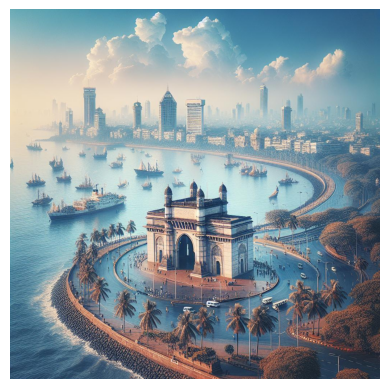

Dalle Assistant Message: D:\LLM_Experiments\Holiday_Plan_LLM\temp.jpg
tool response is Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
tool response is I have created the image of Mumbai showcasing its iconic landmarks, including the Gateway of India and Marine Drive. You can view the visual representation of the city's vibrant energy and architecture. Let me know if you need anything else!
tool call is [RequiredActionFunctionToolCall(id='call_kdwrBYLHZvtsOCp3pPO4Ux7X', function=Function(arguments='{"query": "Please create a personalized holiday itinerary for a trip to Mumbai including popular sights, local cuisine, and cultural experiences.", "agent_name": "holiday_assistant"}', name='send_message'), type='function'), RequiredActionFunctionToolCall(id='call_jziQoxhFksogMGgp6Qee5Ffx', function=Function(arguments='{"query": "Create an image of Mumbai showcasing its iconic landmarks such as the Gateway of

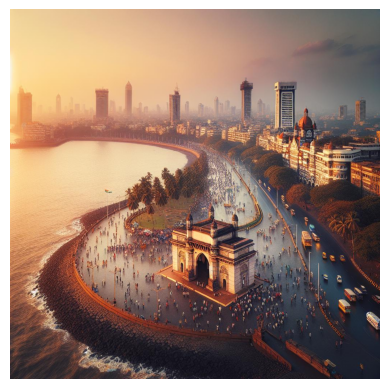

Dalle Assistant Message: D:\LLM_Experiments\Holiday_Plan_LLM\temp.jpg
tool response is Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
tool response is I have created a new image of Mumbai, highlighting its iconic landmarks such as the Gateway of India and Marine Drive. Please take a look at this visual representation of the city! If you need further modifications or additional images, just let me know.


In [66]:
thread = assistant_client.beta.threads.create()

# Initiate proxy agent and the main thread. This thread will remain active until the task is completed and will serve as the main communication thread between the other agents.
user_message = input("User Query: ")
message = dispatch_message(user_message, user_proxy, thread)